In [ ]:
!pip install pytorch_lightning

     |████████████████████████████████| 525 kB 4.3 MB/s 
     |████████████████████████████████| 332 kB 47.4 MB/s 
     |████████████████████████████████| 596 kB 45.8 MB/s 
     |████████████████████████████████| 829 kB 64.4 MB/s 
     |████████████████████████████████| 132 kB 63.6 MB/s 
     |████████████████████████████████| 1.1 MB 50.2 MB/s 
     |████████████████████████████████| 192 kB 61.8 MB/s 
     |████████████████████████████████| 160 kB 65.4 MB/s 
     |████████████████████████████████| 271 kB 65.9 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=b8f08e05aba36862a2e4714e3e44918106afac647d0fc5d64bd09d3af9eb004c
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found exis

In [ ]:
!pip install -q kaggle 

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/ai4good/kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d 'johnowhitaker/opencitiestilesmasked'

100% 8.74G/8.74G [03:06<00:00, 53.4MB/s]
100% 8.74G/8.74G [03:06<00:00, 50.3MB/s]


In [ ]:
import torch
from torch import nn
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import Callback
from torch.optim import lr_scheduler
import albumentations as A
from tqdm.auto import tqdm
from torchvision import transforms
import torchvision
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from skimage import color
import numpy as np
import os, time, pickle, json 
from glob import glob 
from PIL import Image
import cv2 
from typing import List, Tuple, Dict
from statistics import mean 
import torch.nn.functional as F
from collections import OrderedDict

In [ ]:
os.mkdir('oc')
import zipfile
with zipfile.ZipFile('/content/opencitiestilesmasked.zip', 'r') as zip_ref:
    zip_ref.extractall('oc')

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
mask_paths = sorted(glob("/content/oc/data/masks-256/*.png"))
image_paths = sorted(glob("/content/oc/data/images-256/*.png"))

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(3, 256, 256)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    fig, ax = plt.subplots(figsize = (15, 5))
    im = ax.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [ ]:
class ShapeNet(LightningModule):

  def __init__(self, in_channels=1, hidden_dim=16, n_classes=3, lr = 0.001):
    self.lr = lr
    super(ShapeNet, self).__init__()
    self.conv1 = self.conv_block(in_channels, hidden_dim)
    self.conv2 = self.conv_block(hidden_dim, hidden_dim * 2)
    self.conv3 = self.conv_block(hidden_dim * 2, hidden_dim * 4, final_layer=True)
    self.fc = nn.Linear(in_features = 3136, out_features = n_classes)
   
  def conv_block(self, in_channels, out_channels, kernel_size = 3, stride = 2, final_layer=False):
    if not final_layer:
            return nn.Sequential(OrderedDict([
                ("Conv2d", nn.Conv2d(in_channels, out_channels, kernel_size, stride)),
                ("BatchNorm", nn.BatchNorm2d(out_channels)),
                ("MaxPool", nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))),
                ("LeakyRelu", nn.LeakyReLU(0.2, inplace=True))
            ])
            )
    else: 
        return nn.Sequential(OrderedDict([
            ("final", nn.Conv2d(in_channels, out_channels, kernel_size, stride))
        ])
        )

  def forward(self, pred, mask):
    x, y = self.conv1(pred), self.conv1(mask)
    loss_1 = F.l1_loss(x, y)
    x, y = self.conv2(x), self.conv2(y)
    loss_2 = F.l1_loss(x, y)
    x, y = self.conv3(x), self.conv3(y)
    loss_3 = F.l1_loss(x, y)
    loss = (loss_1 + loss_2 + loss_3) / 3.0
    return loss

  def training_step(self, batch, batch_idx):
    x, y = batch
    logits = self(x)
    loss = F.nll_loss(logits, y, reduction = 'mean')
    self.log("train_loss", loss)
    return loss

  def validation_step(self, batch, batch_idx):
    x, y = batch
    logits = self(x)
    loss = F.nll_loss(logits, y, reduction = 'mean')
    self.log("step_val_loss", loss)
    return {"step_val_loss": loss}

  def validation_epoch_end(self, validation_step_outputs):
    avg_loss = torch.stack([x['step_val_loss'] for x in validation_step_outputs]).mean()
    print(f"validation loss {avg_loss}")
    self.log("val_loss", avg_loss)
    return {"val_loss": avg_loss}

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
    lr_scheduler = {
        'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.2, patience = 5),
        'monitor': 'val_loss'
    }
    return [optimizer], [lr_scheduler]


In [ ]:
#PyTorch
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

In [ ]:
class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self, resize=True):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        blocks.append(torchvision.models.vgg16(pretrained=True).features[:4].eval())
        #blocks.append(torchvision.models.vgg16(pretrained=True).features[4:9].eval())
        #blocks.append(torchvision.models.vgg16(pretrained=True).features[9:16].eval())
        #blocks.append(torchvision.models.vgg16(pretrained=True).features[16:23].eval())
        for bl in blocks:
            for p in bl.parameters():
                p.requires_grad = False
        self.blocks = torch.nn.ModuleList(blocks)
        self.transform = torch.nn.functional.interpolate
        self.resize = resize
        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def forward(self, input, target, feature_layers=[0, 1, 2, 3], style_layers=[]):
        if input.shape[1] != 3:
            input = input.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)
        input = (input-self.mean) / self.std
        target = (target-self.mean) / self.std
        if self.resize:
            input = self.transform(input, mode='bilinear', size=(224, 224), align_corners=False)
            target = self.transform(target, mode='bilinear', size=(224, 224), align_corners=False)
        loss = 0.0
        x = input
        y = target
        for i, block in enumerate(self.blocks):
            x = block(x)
            y = block(y)
            if i in feature_layers:
                loss += torch.nn.functional.l1_loss(x, y)
            if i in style_layers:
                act_x = x.reshape(x.shape[0], x.shape[1], -1)
                act_y = y.reshape(y.shape[0], y.shape[1], -1)
                gram_x = act_x @ act_x.permute(0, 2, 1)
                gram_y = act_y @ act_y.permute(0, 2, 1)
                loss += torch.nn.functional.l1_loss(gram_x, gram_y)
        return loss

In [ ]:
def crop(image, new_shape):
    '''
    Function for cropping an image tensor: Given an image tensor and the new shape,
    crops to the center pixels (assumes that the input's size and the new size are
    even numbers).
    Parameters:
        image: image tensor of shape (batch size, channels, height, width)
        new_shape: a torch.Size object with the shape you want x to have
    '''
    middle_height = image.shape[2] // 2
    middle_width = image.shape[3] // 2
    starting_height = middle_height - new_shape[2] // 2
    final_height = starting_height + new_shape[2]
    starting_width = middle_width - new_shape[3] // 2
    final_width = starting_width + new_shape[3]
    cropped_image = image[:, :, starting_height:final_height, starting_width:final_width]
    return cropped_image

class ContractingBlock(nn.Module):
    '''
    ContractingBlock Class
    Performs two convolutions followed by a max pool operation.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super(ContractingBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels * 2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(input_channels * 2, input_channels * 2, kernel_size=3, padding=1)
        self.activation = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        if use_bn:
            self.batchnorm = nn.BatchNorm2d(input_channels * 2)
        self.use_bn = use_bn
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x):
        '''
        Function for completing a forward pass of ContractingBlock: 
        Given an image tensor, completes a contracting block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv1(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.maxpool(x)
        return x

class ExpandingBlock(nn.Module):
    '''
    ExpandingBlock Class:
    Performs an upsampling, a convolution, a concatenation of its two inputs,
    followed by two more convolutions with optional dropout
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super(ExpandingBlock, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=2)
        self.conv2 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(input_channels // 2, input_channels // 2, kernel_size=2, padding=1)
        if use_bn:
            self.batchnorm = nn.BatchNorm2d(input_channels // 2)
        self.use_bn = use_bn
        self.activation = nn.ReLU()
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x, skip_con_x):
        '''
        Function for completing a forward pass of ExpandingBlock: 
        Given an image tensor, completes an expanding block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
            skip_con_x: the image tensor from the contracting path (from the opposing block of x)
                    for the skip connection
        '''
        x = self.upsample(x)
        x = self.conv1(x)
        skip_con_x = crop(skip_con_x, x.shape)
        x = torch.cat([x, skip_con_x], axis=1)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv3(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        return x

class FeatureMapBlock(nn.Module):
    '''
    FeatureMapBlock Class
    The final layer of a U-Net - 
    maps each pixel to a pixel with the correct number of output dimensions
    using a 1x1 convolution.
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)

    def forward(self, x):
        '''
        Function for completing a forward pass of FeatureMapBlock: 
        Given an image tensor, returns it mapped to the desired number of channels.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv(x)
        return x

In [ ]:
class UNet(nn.Module):
    '''
    U-Net
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels, hidden_channels=32):
        super(UNet, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.map = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_dropout=True)
        self.contract2 = ContractingBlock(hidden_channels * 2, use_dropout=True)
        self.contract3 = ContractingBlock(hidden_channels * 4, use_dropout=True)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        self.contract5 = ContractingBlock(hidden_channels * 16)
        #self.contract6 = ContractingBlock(hidden_channels * 32)
        #self.expand0 = ExpandingBlock(hidden_channels * 64)
        #self.expand1 = ExpandingBlock(hidden_channels * 32)
        self.expand2 = ExpandingBlock(hidden_channels * 16)
        self.expand3 = ExpandingBlock(hidden_channels * 8)
        self.expand4 = ExpandingBlock(hidden_channels * 4)
        self.expand5 = ExpandingBlock(hidden_channels * 2)
        self.downfeature1 = FeatureMapBlock(hidden_channels*2, hidden_channels)
        self.activation = nn.ReLU()
        self.downfeature2 = FeatureMapBlock(hidden_channels, output_channels)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        '''
        Function for completing a forward pass of UNet: 
        Given an image tensor, passes it through U-Net and returns the output.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        map = self.map(x)
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        x5 = self.contract5(x4)
        #x6 = self.contract6(x5)
        #x7 = self.expand0(x6, x5)
        #x8 = self.expand1(x7, x4)
        x9 = self.expand2(x4, x3)
        x10 = self.expand3(x9, x2)
        x11 = self.expand4(x10, x1)
        x12 = self.expand5(x11, x0)
        concat = torch.cat((x12, map), axis=1)
        xn = self.downfeature1(concat)
        xn = self.activation(xn)
        xn = self.downfeature2(xn)
        return self.sigmoid(xn)

In [ ]:
#perceptual_loss = ShapeNet().to(device)
perceptual_loss = ShapeNet.load_from_checkpoint(checkpoint_path="drive/MyDrive/ai4good/shapenetshapenet.ckpt").to(device)
#perceptual_loss = VGGPerceptualLoss().to(device)
iou = IoULoss().to(device)

In [ ]:
lambda_recon = 900
n_epochs = 2
input_dim = 3
out_dim = 1
display_step = 2000
batch_size = 4
lr = 0.0005

In [ ]:
weight_decay = 1e-9
min_lr        = 1e-6
T_max         = int(100*6*1.8)
T_0           = 1
T_mult        = 2

In [ ]:
class GAN(LightningModule):
    def __init__(
        self,
        gen, 
        step: int = 0,
        lr: float = lr,
        b1: float = 0.5,
        b2: float = 0.999,
        momentum = 0.9,
        batch_size: int = batch_size,
        display_step: int = display_step,
        **kwargs
    ):
        super().__init__()
        self.save_hyperparameters()

        # networks
        self.gen = gen

        self.step = step
        self.display_step = display_step
        self.lr = lr
        self.b1 = b1
        self.b2 = b2
        self.momentum = momentum


    def forward(self, x):
        return self.gen(x)

    def adv_criterion(self, y_hat, y):
        return F.binary_cross_entropy_with_logits(y_hat, y)

    def recon_criterion(self, y_hat, y):
        return F.l1_loss(y_hat, y)

    def training_step(self, batch, batch_idx):
        image, mask = batch
        mask = mask.to(device).float()
        image = image.to(device).float()
            ### Update generator ###

        if batch_idx % self.display_step == 0:
            print("display _ Step")
        ### Visualization code ###
            fake_map = self.gen(image)
            show_tensor_images(image, size=(input_dim, target_shape, target_shape))
            show_tensor_images(mask, size=(out_dim, target_shape, target_shape))
            show_tensor_images(fake_map, size=(out_dim, target_shape, target_shape))


        gen_loss, iou_loss = self.get_gen_loss(image, mask)
        self.log("iou", iou_loss)
        tqdm_dict = {"gen_loss": gen_loss, "iou": iou_loss}
        output = OrderedDict({"loss": gen_loss, "progress_bar": tqdm_dict, "log": tqdm_dict})
        return output
            

    def configure_optimizers(self):
        #lr = self.hparams.lr
        #b1 = self.hparams.b1
        #b2 = self.hparams.b2
        #opt = torch.optim.Adam(self.gen.parameters(), lr=self.lr, betas=(self.b1, self.b2), weight_decay= weight_decay)
        opt = torch.optim.SGD(self.gen.parameters(), lr=self.lr, momentum=self.momentum, weight_decay=weight_decay)
        #scheduler = lr_scheduler.CosineAnnealingLR(opt,T_max=T_max, 
        #                                           eta_min=min_lr)
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(opt,T_0=T_0, 
                                                             eta_min=min_lr)
        #scheduler = lr_scheduler.ReduceLROnPlateau(opt,
                                                   #mode='min',
                                                   #factor=0.1,
                                                   #patience=7,
                                                   #threshold=0.0001,
                                                   #min_lr=min_lr,)
        return {"optimizer": opt,
                "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "iou"
                },}


    def get_gen_loss(self, image, mask):
        '''
        Return the loss of the generator given inputs.
        Parameters:
            gen: the generator; takes the condition and returns potential images
            disc: the discriminator; takes images and the condition and
              returns mask/fake prediction matrices
            mask: the mask images (e.g. maps) to be used to evaluate the reconstruction
            image: the satellite images) which are used to produce the masks
            adv_criterion: the adversarial loss function; takes the discriminator 
            predictions and the true labels and returns a adversarial loss 
            recon_criterion: the reconstruction loss function; takes the generator 
            outputs and the masks and returns a reconstruction loss 
            lambda_recon: the degree to which the reconstruction loss should be weighted in the sum
            #found higher to be better pix2pix used 200
        '''
        fake = self.gen(image)
        gen_rec_loss = self.recon_criterion(mask, fake)
        p_loss = perceptual_loss(fake, mask)
        iou_loss = iou(fake, mask)
        gen_loss = lambda_recon * gen_rec_loss + p_loss + iou_loss
        return gen_loss, iou_loss

In [ ]:
#dataset = []
#with open(r"/content/drive/MyDrive/ai4good/okdataset2_buildings.pkl", "rb") as file:
#  dataset = pickle.load(file)
#with open(r"/content/drive/MyDrive/ai4good/okdataset1_buildings.pkl", "rb") as file:
#  dataset = dataset + pickle.load(file)
#with open(r"/content/drive/MyDrive/ai4good/okdataset3_buildings.pkl", "rb") as file:
#  dataset = dataset + pickle.load(file)
#with open(r"/content/drive/MyDrive/ai4good/okdataset4_buildings.pkl", "rb") as file:
#  dataset = dataset + pickle.load(file)

In [ ]:
#plt.imshow(dataset[888][0])

In [ ]:
#plt.imshow(np.squeeze(dataset[888][1]))

In [ ]:
#Change to euler folder
#imgs_ = 'enter_mask_patch_paths'
#masks_ = 'enter_mask_patch_paths'

#imgs_ = '/content/drive/MyDrive/ai4good/Khartoum/image_patches'
#masks_ = '/content/drive/MyDrive/ai4good/Khartoum/mask_patches'

#img_paths = sorted(glob(imgs_ + "/*.png"))
#mask_paths = sorted(glob(masks_ + "/*.png"))

#Sanity Checks


In [ ]:
target_shape = 256
MEAN = (0.5, 0.5, 0.5,)
STD = (0.5, 0.5, 0.5,)
SIZE = 256

class Transform():
    def __init__(self, mean=MEAN, std=STD):
        self.data_transform = transforms.Compose([ 
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        
    def __call__(self, img: Image.Image):
        return self.data_transform(img)

class Mask_Transform():
    def __init__(self):
        self.data_transform = transforms.Compose([ 
            transforms.ToTensor(),
        ])
        
    def __call__(self, img: Image.Image):
        return self.data_transform(img)

    
class Dataset(object):
    def __init__(self, image_paths, mask_paths, aug):
        self.images = image_paths
        self.masks = mask_paths
        self.transformer = Transform()
        self.mask_transform = Mask_Transform()
        self.aug = aug
        
    
    def __getitem__(self, idx: int):
        image = cv2.imread(self.images[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[idx], 0)
        t = self.aug(image = image, mask = mask)
        image = t['image']
        mask = t['mask'] / 255.0

        image = self.transformer(image)
        mask = self.mask_transform(mask)
        return image, mask
    
    def __len__(self):
        return len(self.images)

        

In [ ]:
class Dataset2(object):
    def __init__(self, data, aug):
        self.data = data 
        self.transformer = Transform()
        self.mask_transform = Mask_Transform()
        self.aug = aug

    def __getitem__(self, idx: int):
        image, mask = self.data[idx]
        t = self.aug(image = image, mask = mask)
        image = t['image']
        mask = t['mask'] / 255.0
        image = self.transformer(image)
        mask = self.mask_transform(mask)
        return image, mask
        

    
    def __len__(self):
        return len(self.data)

In [ ]:
train_transforms = A.Compose([# D4 Group augmentations
                #A.HorizontalFlip(p=0.5),
                #A.VerticalFlip(p=0.5),
                #A.RandomRotate90(p=0.5),
                A.RandomBrightnessContrast(brightness_limit = 0.1, contrast_limit = 0.1, p = 0.5),                 
                #A.Normalize(mean = MEAN, std = STD)
                ])

In [ ]:
#use this to load images per batch slow and sometimes runs a pytorch error
#still investigating
#data_read = list(zip(img_paths, mask_paths))
#train_read = Dataset_read(data_read)
#train_ds = Dataset2(dataset, aug = train_transforms)
train_ds = Dataset(image_paths = image_paths, mask_paths = mask_paths, aug = train_transforms)

In [ ]:
#len(train_read)

In [ ]:
len(train_ds)

23607

In [ ]:
#uncomment if not loading old model
gen = UNet(3, 1).to(device)

#disc = Discriminator(input_dim + out_dim).to(device)


def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
#uncomment only if start new training
#gen = gen.apply(weights_init)
#disc = disc.apply(weights_init)

In [ ]:
gen = gen.apply(weights_init)

In [ ]:
#gen.load_state_dict(torch.load('/content/drive/MyDrive/ai4good/edge_forward_gen_shape.pth'))

In [ ]:
model = GAN(gen = gen)

In [ ]:
dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers = 4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


display _ Step


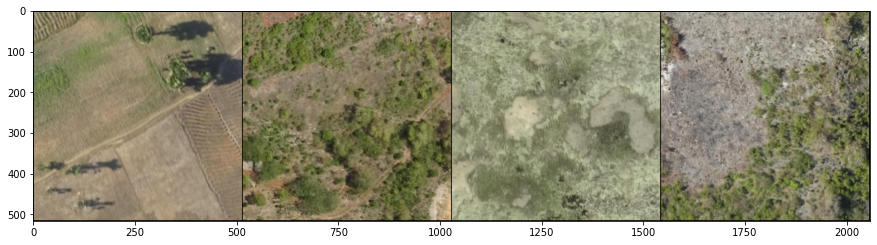

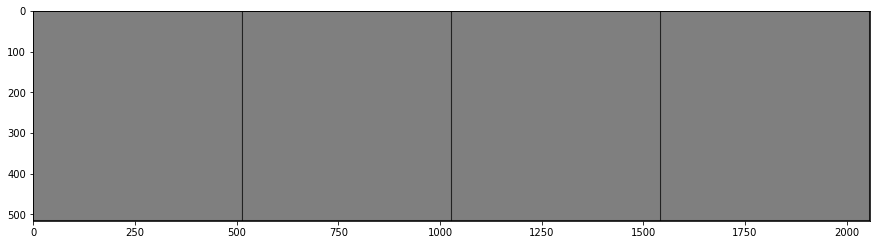

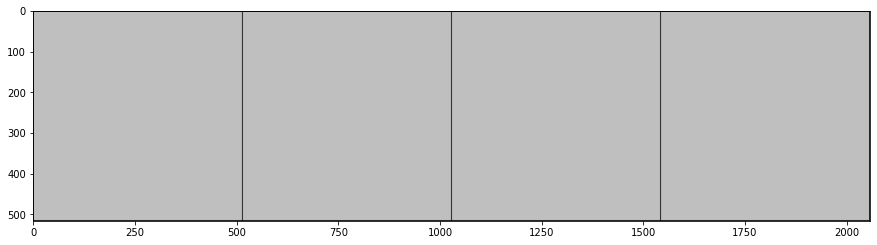

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/optimization/closure.py:36: LightningDeprecationWarning: One of the returned values {'log', 'progress_bar'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /content/lr_find_temp_model_47a1f204-45ca-4634-8595-44ac0e7471ee.ckpt


In [ ]:
trainer = Trainer(gpus=1, max_epochs=50, accumulate_grad_batches=8)

# Run learning rate finder
lr_finder = trainer.tuner.lr_find(model, dataloader)

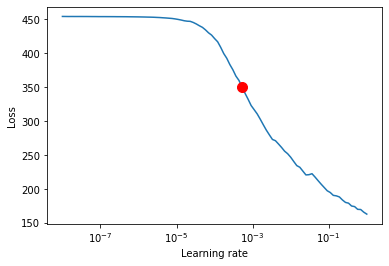

In [ ]:
# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

In [ ]:
# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
new_lr

0.0005248074602497723

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | gen  | UNet | 21.5 M
------------------------------
21.5 M    Trainable params
0         Non-trainable params
21.5 M    Total params
85.919    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


display _ Step


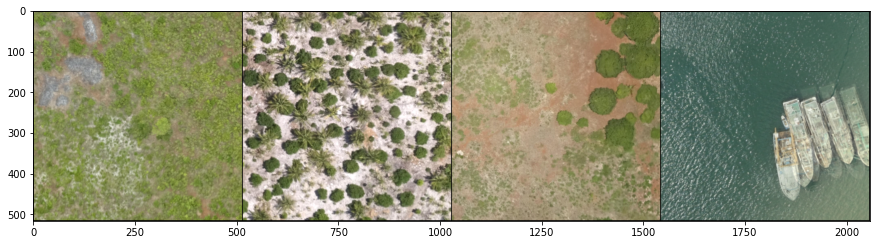

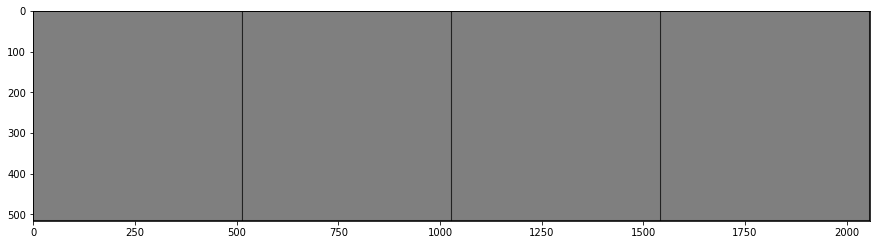

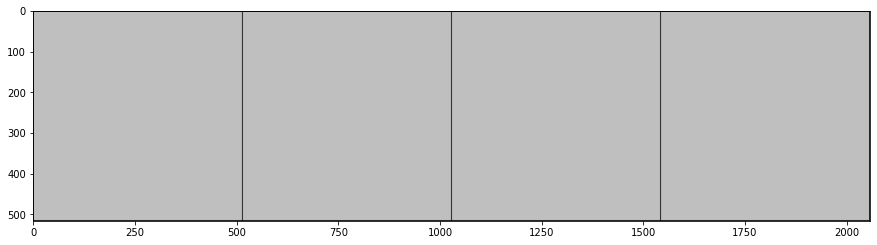

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/optimization/closure.py:36: LightningDeprecationWarning: One of the returned values {'log', 'progress_bar'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


display _ Step


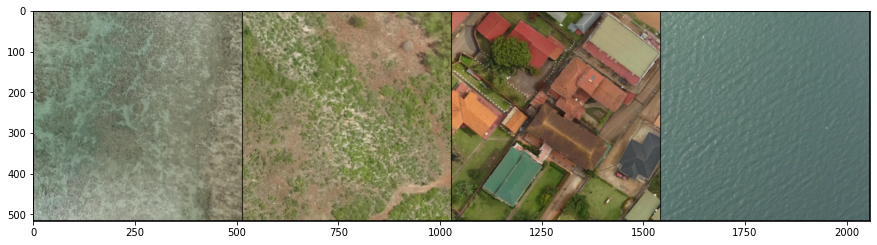

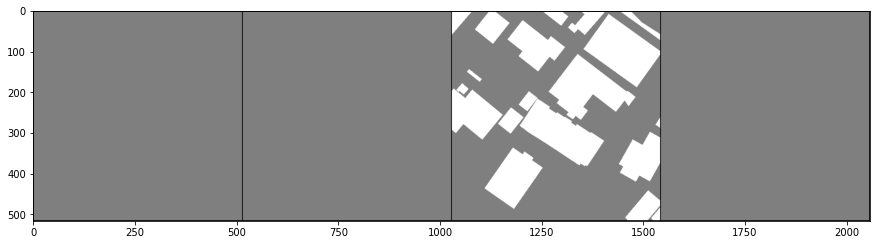

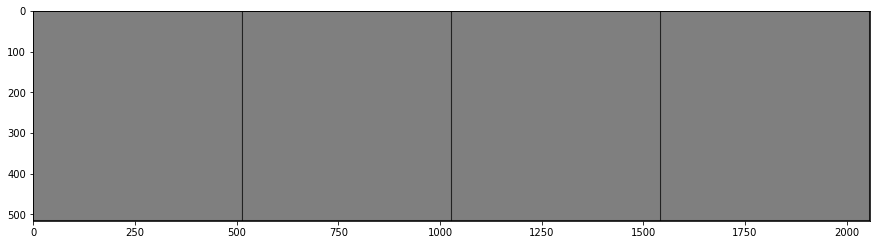

display _ Step


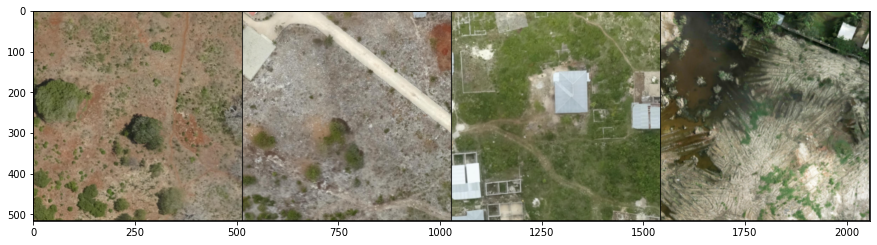

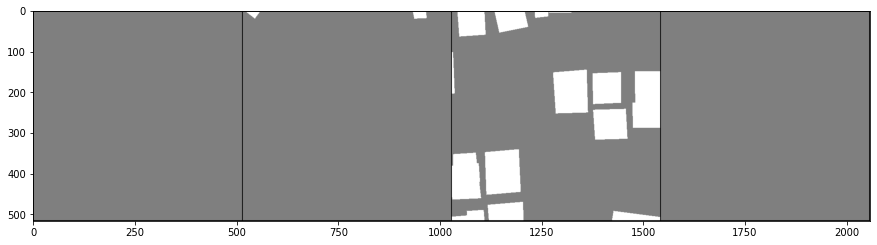

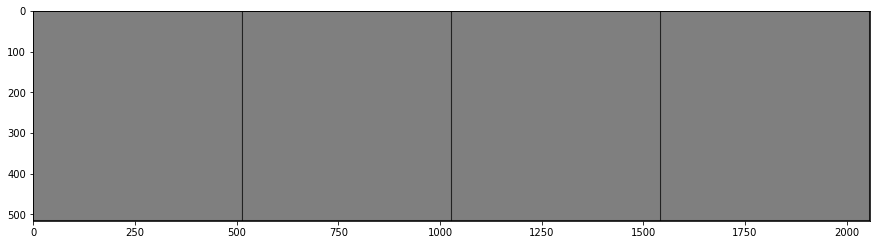

display _ Step


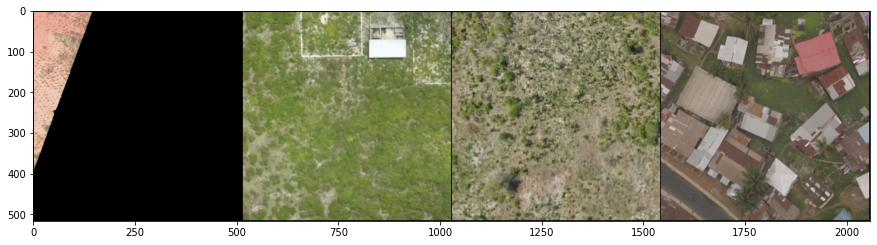

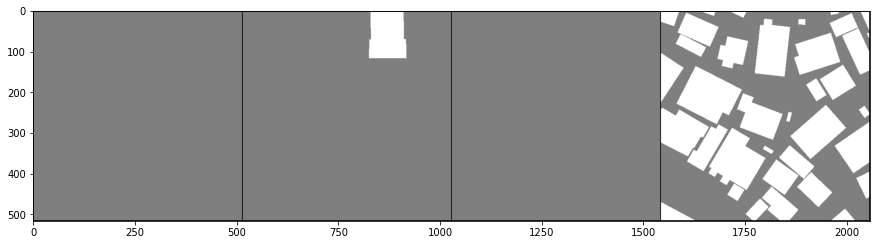

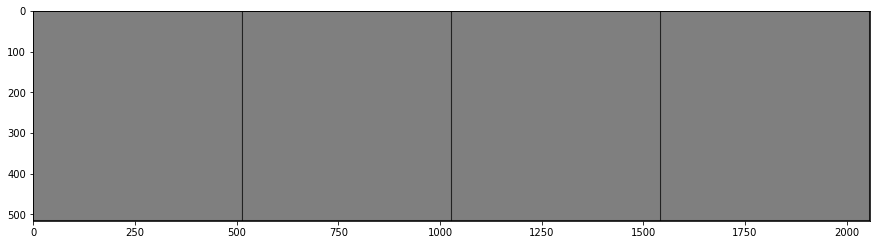

display _ Step


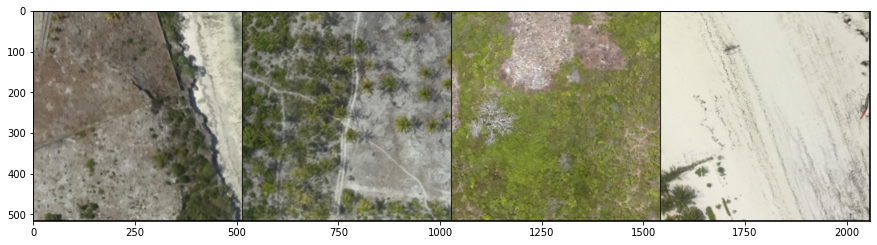

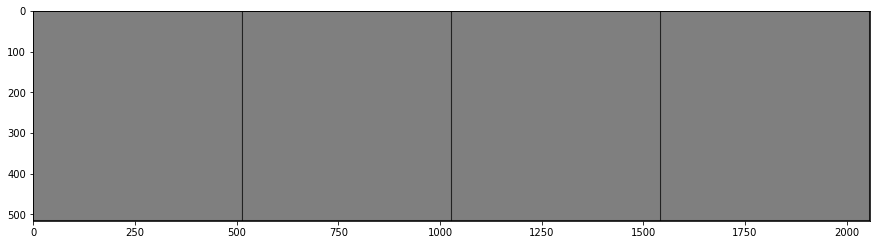

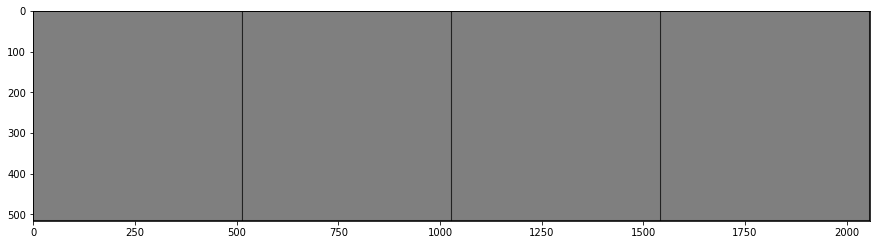

display _ Step


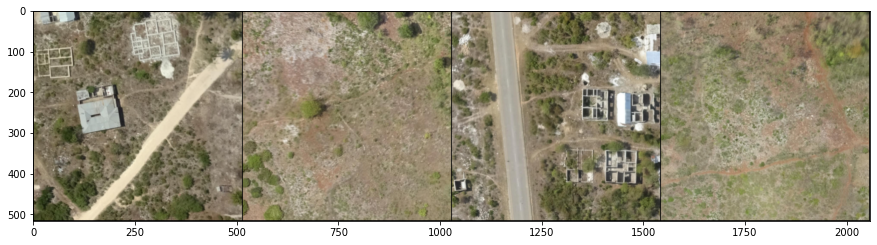

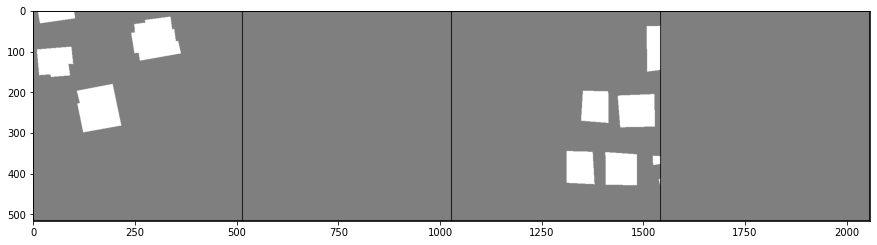

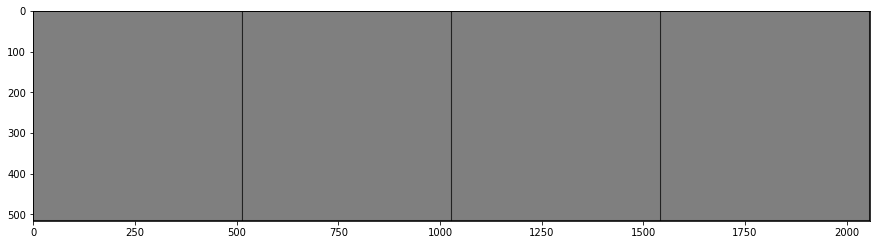

display _ Step


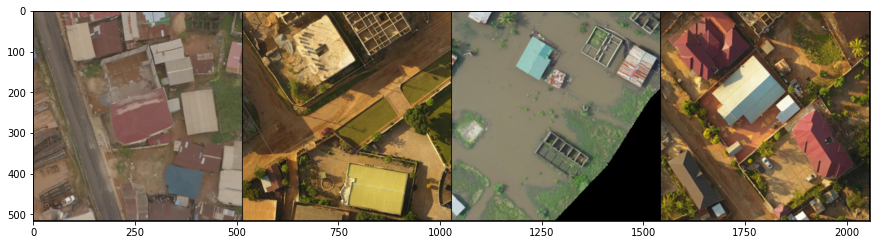

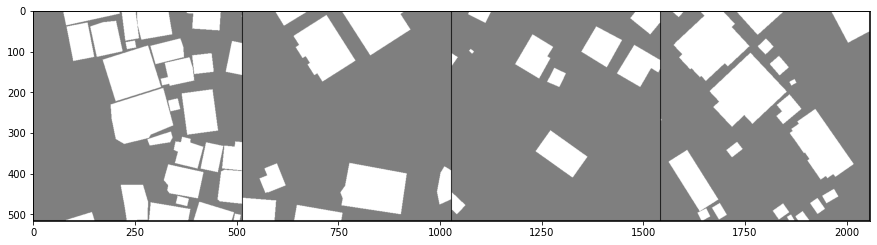

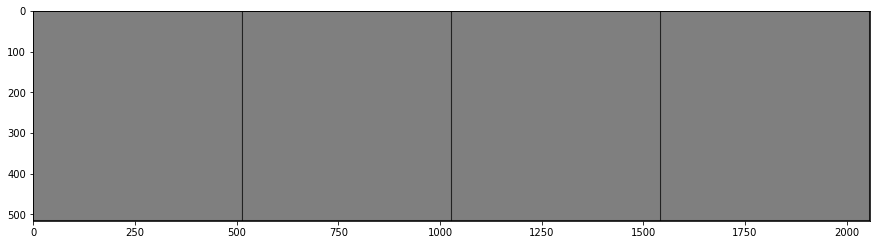

In [ ]:
# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()

#update hparams of the model
model.hparams.lr = new_lr

# Fit model
trainer.fit(model, dataloader)

In [ ]:
#trainer = Trainer(gpus=1, max_epochs=50, accumulate_grad_batches=8)
#trainer.fit(model, dataloader)

In [ ]:
#safety save
#torch.save(gen.state_dict(), '/content/drive/MyDrive/ai4good/edge_forward_gen3.pth')
#torch.save(disc.state_dict(), '/content/drive/MyDrive/ai4good/pix2pixdisc_blds.pth')

In [ ]:
#trainer.save_checkpoint("/content/drive/MyDrive/ai4good/edge_forward3.ckpt")

In [ ]:
torch.save(gen.state_dict(), '/content/drive/MyDrive/ai4good/edge_forward_gen_shape2.pth')

In [ ]:
batch = next(iter(dataloader))
image, mask = batch
fake_map = gen(image)
show_tensor_images(image, size=(input_dim, target_shape, target_shape))
show_tensor_images(mask, size=(out_dim, target_shape, target_shape))
show_tensor_images(fake_map, size=(out_dim, target_shape, target_shape))

In [ ]:
batch = next(iter(dataloader))
image, mask = batch
fake_map = gen(image)
show_tensor_images(image, size=(input_dim, target_shape, target_shape))
show_tensor_images(mask, size=(out_dim, target_shape, target_shape))
show_tensor_images(fake_map, size=(out_dim, target_shape, target_shape))

In [ ]:
batch = next(iter(dataloader))
image, mask = batch
fake_map = gen(image)
show_tensor_images(image, size=(input_dim, target_shape, target_shape))
show_tensor_images(mask, size=(out_dim, target_shape, target_shape))
show_tensor_images(fake_map, size=(out_dim, target_shape, target_shape))